In [19]:
##SKLEARN
#Import scikit-learn metrics module for accuracy calculation}
from sklearn import metrics
#TSNE exploration
from sklearn.manifold import TSNE
#PCA
from sklearn.decomposition import PCA
##ML models and feature selection
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

##Matplotlib
import matplotlib.pyplot as plt
# unused but required import for doing 3d projections with matplotlib < 3.2
from mpl_toolkits import mplot3d
import seaborn as sns
#OpenCV
import cv2

#Utility functions for dataset management
import ast
import copy
import pandas as pd
import os
import numpy as np

#Load in the dataset
hcf_colnames = ["Instance", "No_In_Sequence", "Class", "Freeze", "Obstacle", "Person", "Feet_Height_0", "Feet_Height_1",
                 "Time_LOG_0", "Time_LOG_1", "Time_No_Movement", "Speed", "Stride_Gap", "Stride_Length", "Max_Gap", 'l_co 1',
                 'l_co 2', 'l_co 3', 'l_co 4', 'l_co 5', 'l_co 6', 'l_co 7', 'r_co 1', 'r_co 2', 'r_co 3', 'r_co 4', 'r_co 5', 'r_co 6', 'r_co 7']

dataset_master = pd.read_csv("../../Datasets/Joint_Data/Chris/13.5_HCF_Data(normed)/raw/13.5_HCF_Data(normed).csv", \
                             names=hcf_colnames, header=None)

#Remove eyes and ear joints
#dataset_master = dataset_master.drop(["Joint_2","Joint_3","Joint_4","Joint_5"], axis = 1)

#Dataset is currently 2 instances worth of severe gait obstruction (simulated parkinson's).
dataset_master.head()

,Instance,No_In_Sequence,Class,Freeze,Obstacle,Person,Feet_Height_0,Feet_Height_1,Time_LOG_0,Time_LOG_1,...,l_co 5,l_co 6,l_co 7,r_co 1,r_co 2,r_co 3,r_co 4,r_co 5,r_co 6,r_co 7
0,0,6,0,0,0,0,0.073159,0.147468,0.000,0.250,...,0.423855,0.525826,0.201509,0.402431,0.590380,0.446970,0.530699,0.436032,0.690551,0.251375
1,0,16,0,0,0,0,0.115242,0.088953,0.250,0.125,...,0.656634,0.357877,0.243408,0.337871,0.672637,0.353893,0.617822,0.421717,0.546587,0.317526
2,0,25,0,0,0,0,0.049721,0.075476,0.125,0.125,...,0.420246,0.402809,0.583980,0.356045,0.656694,0.363370,0.616055,0.427909,0.512467,0.349763
3,0,35,0,0,0,0,0.066603,0.078289,0.375,0.500,...,0.431140,0.482832,0.353654,0.399107,0.590542,0.457398,0.488585,0.581763,0.444398,0.328741
4,1,17,0,0,0,0,0.091679,0.067721,0.125,0.125,...,0.390424,0.481454,0.666367,0.685525,0.335859,0.651907,0.371817,0.597527,0.494792,0.243589


In [20]:
################CHARTING FUNCTIONS ########################################
###########################################################################
def create_adjacency_matrices(data_reg, data_limp, data_stagger, len_data):
    
    data = []
    
    for i in range(len_data):
        #Combine first joint of all 3 classes into one dataframe of instances
        tmp_reg = data_reg[i]
        tmp_limp = data_limp[i]
        tmp_stagger = data_stagger[i]

        #print("lens of individuals: ", tmp_reg.shape, tmp_limp.shape, tmp_stagger.shape)

        combined_joint_data = tmp_reg.append(tmp_limp, ignore_index=True)
        combined_joint_data = combined_joint_data.append(tmp_stagger, ignore_index=True)
        data.append(combined_joint_data)
    
    return data

def plot_confusion_matrix(data, title):
    #Plot the x_coord of each joint against eachother (must use all 3 classes)
    for i, joints_data in enumerate(data):
        plt.figure(figsize=(10,5))
        plt.title(title + str(i))
        print("joints data: ", joints_data)
        c= joints_data.corr()
        sns.heatmap(c,cmap="BrBG",annot=True)
        #c

def plot_confusion_results(cm):
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
def plot_scatter_plot(data, index = None, title= "default"):
    if index != None:
        ax1 = combined_joints_data[index].plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data[index].plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data[index].plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
    else:
        ax1 = combined_joints_data.plot(kind='scatter', x='z_coord', y='Class', color='r', alpha = 1.0, title = "Joint " + str(i))    
        ax2 = combined_joints_data.plot(kind='scatter', x='x_coord', y='Class', color='g', ax=ax1, alpha = 0.5)    
        ax3 = combined_joints_data.plot(kind='scatter', x='y_coord', y='Class', color='b', ax=ax1, alpha = 0.05)
        
    ax1.set_title(title + str(i))
    ax1.set_xlabel('Class')
    ax1.set_ylabel('x_coord')
    plt.show()
    
def chart_pairplots(data, coord_index, iter_index):
    sns.pairplot(data = combined_joints_data[coord_index], x_vars=combined_joints_data[coord_index].columns[iter_index:iter_index+5], \
            y_vars=['Class'])
    
def generate_PCA(X, y):
    pca_model = PCA(n_components = 10)
    X_reduced = pca_model.fit(X, y).transform(X)
    
    return pca_model, X_reduced

def convert_to_literals(data):

    #Convert all strings in reloaded array back to numbers
    for i,  (index, row) in enumerate(data.iterrows()):
        for col_index, col in enumerate(row):
            if col_index >= 6:
                print("type: ", type(row[col_index]))
                tmp = ast.literal_eval(row[col_index])
                data.iat[i, col_index] = copy.deepcopy(tmp)
            else:
                data.iat[i, col_index] = int(data.iat[i, col_index])
    return data
                
def chart_PCA(pca_features):
    # To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    ax.scatter(
        pca_features[:, 0],
        pca_features[:, 1],
        pca_features[:, 2],
        c=y,
        cmap=plt.cm.Set1,
        edgecolor="k",
        s=40,
    )

    ax.set_title("First Three PCA Directions")
    ax.set_xlabel("1st eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.zaxis.set_ticklabels([])
    plt.show()

def plot_skeleton(row):
    #Remove first 3 values
    data = row[3:]
    x_data = []
    y_data = []
    z_data = []
    counter = 0
    for i, value in enumerate(row):
        if counter == 0:
            x_data.append(value)
            counter += 1
        elif counter == 1:
            y_data.append(value)
            counter += 1
        else:
            z_data.append(value)
            counter = 0

    #Plot the skeleton
    fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #for j, joint in enumerate(x_data):
        #print("point number: ", j, " is: (", x_data[j], y_data[j], z_data[j], ")")
    #ax.scatter3D(y_data, x_data, z_data, c=z_data);
    plt.scatter(y_data, x_data)

def set_data(data, legs_only, legs = False):
    if legs == False:
        X = data.drop(['Class', 'Instance', 'No_In_Sequence', ], axis = 1)
    else:
        X = legs_only

    return X, data['Class']

################MODEL FUNCTIONS ########################################
###########################################################################
def run_SVM_test(X, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=23) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return clf, y_test, y_pred

def run_LOGREG_test(X,y):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=13) # 70% training and 30% test

    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()

    logisticRegr.fit(X_train, y_train)

    # Returns a NumPy Array
    # Predict for One Observation (image)
    #logisticRegr.predict(x_test[0].reshape(1,-1))

    #Or predict entire dataset at once
    y_pred = logisticRegr.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    # Model Precision:what percentage of positive tuples are labeled as such?
    print("\nPrecision:",metrics.precision_score(y_test, y_pred, average = 'weighted'))
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("\nRecall:",metrics.recall_score(y_test, y_pred, average = 'weighted'))

    return logisticRegr, y_test, y_pred

In [21]:
#dataset_master = convert_to_literals(dataset_master)
dataset_master.dtypes

Instance              int64
No_In_Sequence        int64
Class                 int64
Freeze                int64
Obstacle              int64
Person                int64
Feet_Height_0       float64
Feet_Height_1       float64
Time_LOG_0          float64
Time_LOG_1          float64
Time_No_Movement    float64
Speed               float64
Stride_Gap          float64
Stride_Length       float64
Max_Gap             float64
l_co 1              float64
l_co 2              float64
l_co 3              float64
l_co 4              float64
l_co 5              float64
l_co 6              float64
l_co 7              float64
r_co 1              float64
r_co 2              float64
r_co 3              float64
r_co 4              float64
r_co 5              float64
r_co 6              float64
r_co 7              float64
dtype: object

joints data:       Instance  No_In_Sequence  Class  Freeze  Obstacle  Person  Feet_Height_0  \
0           0               6      0       0         0       0       0.073159   
1           0              16      0       0         0       0       0.115242   
2           0              25      0       0         0       0       0.049721   
3           0              35      0       0         0       0       0.066603   
4           1              17      0       0         0       0       0.091679   
..        ...             ...    ...     ...       ...     ...            ...   
179        58              24      2       0         1       0       0.052391   
180        58              44      2       0         1       0       0.050350   
181        59              14      2       0         1       0       0.086557   
182        59              22      2       0         1       0       0.092344   
183        59              42      2       0         1       0       0.068123   

     Feet_Hei

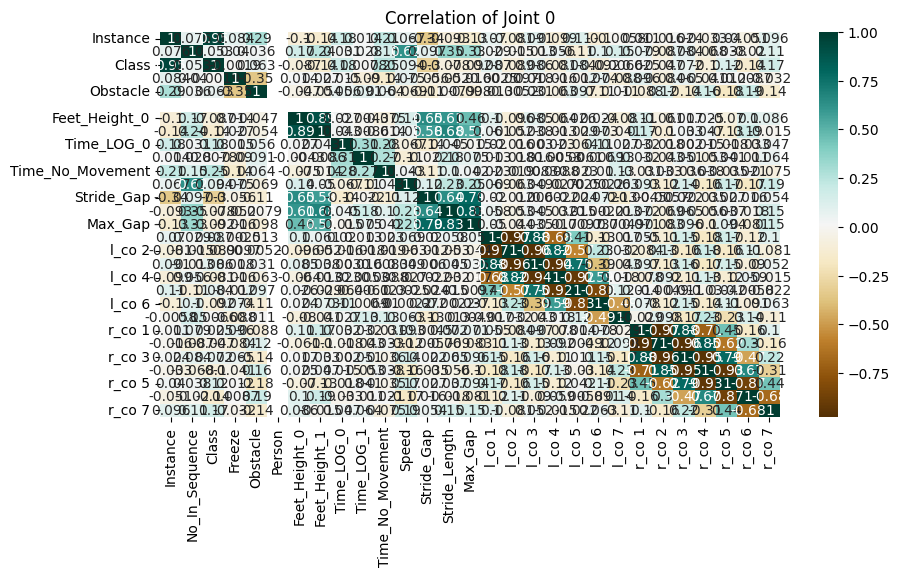

In [22]:
#dataset_master = dataset_master.drop(['Instance', 'No_In_Sequence'], axis = 1)
dataset_array = dataset_master
plot_confusion_matrix([dataset_array], "Correlation of Joint ")

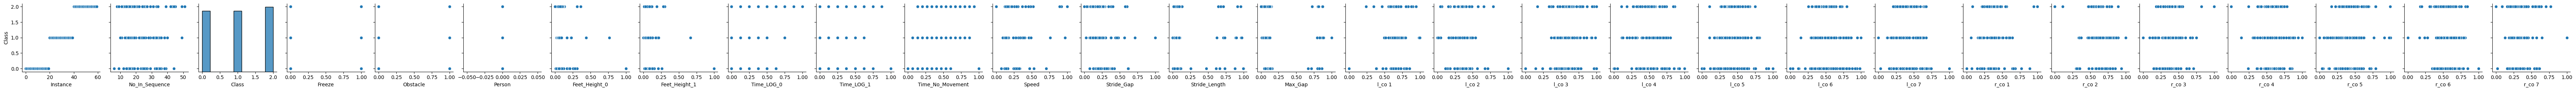

In [23]:
sns.pairplot(data = dataset_master, x_vars=dataset_master.columns, \
            y_vars=['Class'])

In [24]:
dataset_master = dataset_master.drop(["Feet_Height_0_2","Feet_Height_0_3",\
            "Feet_Height_1_2","Feet_Height_1_3",\
            "Time_LOG_0_2","Time_LOG_0_3", \
            "Time_LOG_1_2","Time_LOG_1_3",\
            "Time_No_Movement_2","Time_No_Movement_3",\
            "Speed_2","Speed_3", \
            "Stride_Gap_2","Stride_Gap_3",\
            "Stride_Length_2","Stride_Length_3",\
            "Max_Gap_2","Max_Gap_3", \
            'l_co 1x','l_co 1y', 'l_co 1z', \
            'l_co 2x','l_co 2y', 'l_co 2z', \
            'l_co 3x','l_co 3y', 'l_co 3z', \
            'l_co 4x','l_co 4y', 'l_co 4z', \
            'l_co 5x','l_co 5y', 'l_co 5z', \
            'l_co 6x','l_co 6y', 'l_co 6z', \
            'l_co 7x','l_co 7y', 'l_co 7z', \
            'r_co 1x','r_co 1y', 'r_co 1z', \
            'r_co 2x','r_co 2y', 'r_co 2z', \
            'r_co 3x','r_co 3y', 'r_co 3z', \
            'r_co 4x','r_co 4y', 'r_co 4z', \
            'r_co 5x','r_co 5y', 'r_co 5z', \
            'r_co 6x','r_co 6y', 'r_co 6z', \
            'r_co 7x','r_co 7y', 'r_co 7z'], axis = 1)

#Random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
import time

#Set data for experiment
X, y = set_data(dataset_master, [], legs = False)
    
    #hcf_colnames = ['Instance', 'No_In_Sequence', 'Class',
    #'Feet_height_0', 'Feet_height_1', # Dogshit
    #"Time_LOG_0", "Time_LOG_1", # Also Dogshit
    #  "Time_not_moving", 'Speed', #Awful, then decent
    #'Stride_gap_avg', 'Stride_gap_max', #Very good, then shite
    #'Stride_length_ratio'] # average
    
#X = X.drop(['Feet_height_1', 'Time_LOG_0',,
#              "Time_not_moving", "Stride_gap_max"], axis = 1)
X, y = shuffle(X, y, random_state=42)
print(X.head())
X = X.to_numpy()
y = y.to_numpy()

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #Train the forest classifier
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)

    #Calculate feature importance
    start_time = time.time()
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

    #Plot the results
    forest_importances = pd.Series(result.importances_mean, index=feature_names)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    
    #hcf_colnames = ['Instance', 'No_In_Sequence', 'Class',
    #'Feet_height_0', 'Feet_height_1', # Dogshit
    #"Time_LOG_0", "Time_LOG_1", # Also Dogshit
    #  "Time_not_moving", 'Speed', #Awful, then decent
    #'Stride_gap_avg', 'Stride_gap_max', #Very good, then shite
    #'Stride_length_ratio'] # average
    
    #From this we know Speed is important, Stride gap average which is stride length essentially

KeyError: "['Feet_Height_0_2', 'Feet_Height_0_3', 'Feet_Height_1_2', 'Feet_Height_1_3', 'Time_LOG_0_2', 'Time_LOG_0_3', 'Time_LOG_1_2', 'Time_LOG_1_3', 'Time_No_Movement_2', 'Time_No_Movement_3', 'Speed_2', 'Speed_3', 'Stride_Gap_2', 'Stride_Gap_3', 'Stride_Length_2', 'Stride_Length_3', 'Max_Gap_2', 'Max_Gap_3', 'l_co 1x', 'l_co 1y', 'l_co 1z', 'l_co 2x', 'l_co 2y', 'l_co 2z', 'l_co 3x', 'l_co 3y', 'l_co 3z', 'l_co 4x', 'l_co 4y', 'l_co 4z', 'l_co 5x', 'l_co 5y', 'l_co 5z', 'l_co 6x', 'l_co 6y', 'l_co 6z', 'l_co 7x', 'l_co 7y', 'l_co 7z', 'r_co 1x', 'r_co 1y', 'r_co 1z', 'r_co 2x', 'r_co 2y', 'r_co 2z', 'r_co 3x', 'r_co 3y', 'r_co 3z', 'r_co 4x', 'r_co 4y', 'r_co 4z', 'r_co 5x', 'r_co 5y', 'r_co 5z', 'r_co 6x', 'r_co 6y', 'r_co 6z', 'r_co 7x', 'r_co 7y', 'r_co 7z'] not found in axis"

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle


skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

print(skf)
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
   # y_test_true = y_true[test_index]


    
    SVM_classifier, y_test, y_pred = run_SVM_test(X, y)
    y_test = pd.Series(y_test)
    print(y_test.value_counts())

#Speed is 100% wrong, same with s
#Feet height 0 is useless, maybe use a ratio?
#Time not moving not very accurate

typez  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
Accuracy: 0.6097560975609756

Precision: 0.6287262872628726

Recall: 0.6097560975609756
2    16
1    14
0    11
dtype: int64
Accuracy: 0.6097560975609756

Precision: 0.6287262872628726

Recall: 0.6097560975609756
2    16
1    14
0    11
dtype: int64


In [9]:
dataset_master = pd.read_csv("./Finished_Data/hcf_dataset_pixels.csv", names=hcf_colnames, header=None)
dataset_master.plot(x='Class', y='Stride_gap_max', style='o')

FileNotFoundError: [Errno 2] No such file or directory: './Finished_Data/hcf_dataset_pixels.csv'

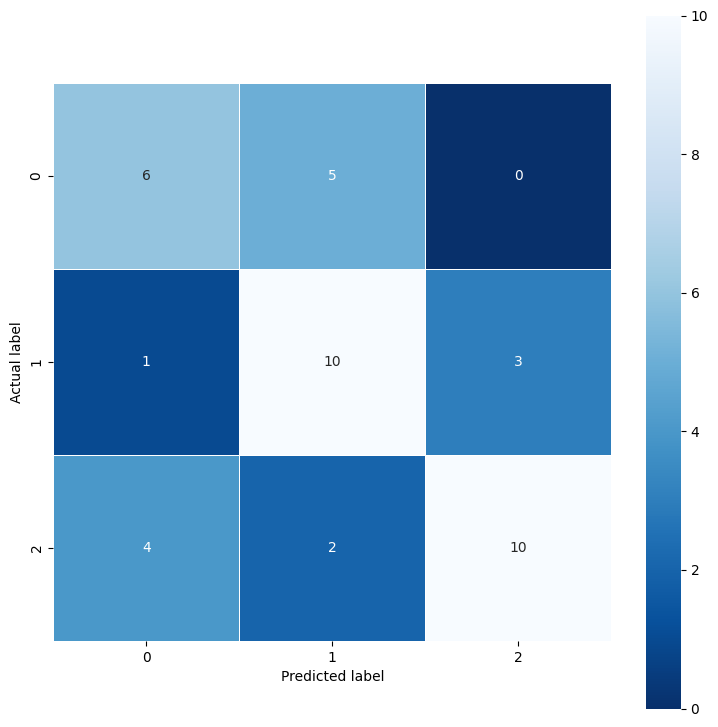

In [10]:
#log_classifier, y_test, y_pred = run_LOGREG_test(X, y)
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_results(cm)

In [11]:
#Try and normalize all values between 0-1

#PCA features

#Revise/ add features

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 184 samples in 0.000s...
[t-SNE] Computed neighbors for 184 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 0.018703
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.888901
[t-SNE] KL divergence after 900 iterations: 0.157580


C:\Users\chris\AppData\Local\Temp\ipykernel_28020\3150577829.py:24: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),


[Text(0.5, 1.0, 'T-SNE projection')]

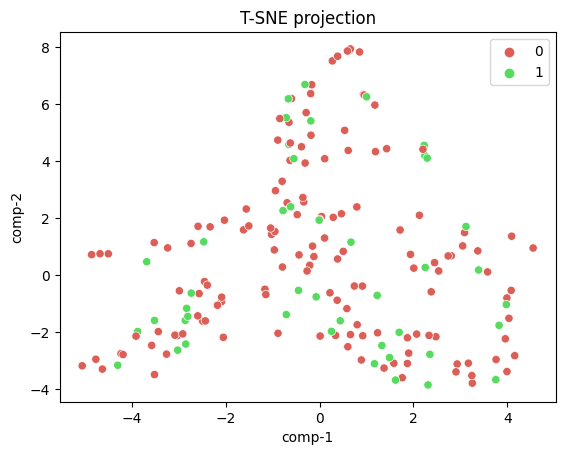

In [40]:
X = dataset_master.drop(['Class', 'Instance', 'No_In_Sequence', "Freeze", "Obstacle", "Person"], axis = 1)
y = dataset_master['Obstacle']

#hcf_colnames = ["Instance", "No_In_Sequence", "Class", "Freeze", "Obstacle", "Person", "Feet_Height_0", "Feet_Height_1",
#                 "Time_LOG_0", "Time_LOG_1", "Time_No_Movement", "Speed", "Stride_Gap", "Stride_Length", "Max_Gap", 'l_co 1',
#                 'l_co 2', 'l_co 3', 'l_co 4', 'l_co 5', 'l_co 6', 'l_co 7', 'r_co 1', 'r_co 2', 'r_co 3', 'r_co 4', 'r_co 5', 'r_co 6', 'r_co 7']

test_cases = [['l_co 2', 'l_co 3', 'l_co 4', 'l_co 5', 'l_co 6', 'l_co 7', \
               'r_co 1', 'r_co 2', 'r_co 3', 'r_co 4', 'r_co 5', 'r_co 6', 'r_co 7']]

X = X.drop(['l_co 2', 'l_co 3', 'l_co 4', 'l_co 5', 'l_co 6', 'l_co 7', 'r_co 1', 'r_co 2', 'r_co 3', 'r_co 4', 'r_co 5', 'r_co 6', 'r_co 7'], axis = 1)
X = X.drop(["Time_LOG_0", "Time_LOG_1", "Time_No_Movement"], axis = 1)
#X = X.drop(["Feet_Height_0", "Feet_Height_1"], axis = 1)
X = X.drop(["Stride_Gap", "Stride_Length", "Max_Gap", 'l_co 1'], axis = 1)

tsne = TSNE(n_components=3, verbose=1, random_state=123)
z = tsne.fit_transform(X) 

df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=df).set(title="T-SNE projection") 

